In [1]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector

In [2]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
train_data, test_data = generate_synthetic_data_with_noise(N, z_size, D)

In [7]:
class CEConcreteAutoencoderFeatureSelector(ConcreteAutoencoderFeatureSelector):
    def __init__(self, K, output_function, num_epochs = 300, batch_size = None, learning_rate = 0.001, start_temp = 10.0, min_temp = 0.1, tryout_limit = 5):
            super(CEConcreteAutoencoderFeatureSelector, self).__init__(K, output_function, num_epochs, batch_size, learning_rate, start_temp, min_temp, tryout_limit)
    
    
    def fit(self, X, Y = None, val_X = None, val_Y = None):
        if Y is None:
            Y = X
        assert len(X) == len(Y)
        validation_data = None
        if val_X is not None and val_Y is not None:
            assert len(val_X) == len(val_Y)
            validation_data = (val_X, val_Y)
        
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size
        
        for i in range(self.tryout_limit):
            
            K.set_learning_phase(1)
            
            inputs = Input(shape = X.shape[1:])

            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name = 'concrete_select')

            selected_features = self.concrete_select(inputs)

            outputs = self.output_function(selected_features)

            self.model = Model(inputs, outputs)

            self.model.compile(Adam(self.learning_rate), loss = 'binary_crossentropy')
            
            print(self.model.summary())
            
            stopper_callback = StopperCallback()
            
            hist = self.model.fit(X, Y, self.batch_size, num_epochs, verbose = 1, callbacks = [stopper_callback], validation_data = validation_data)#, validation_freq = 10)
            
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis = -1)))) >= stopper_callback.mean_max_target:
                break
            
            num_epochs *= 2
        
        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
            
        return self

convert torch tensors to tf tensors

In [8]:
def tf_to_to(df):
    df = df.cpu().numpy()
    return tf.convert_to_tensor(df)

In [9]:
#train_data = tf_to_to(train_data)
#test_data = tf_to_to(test_data)

In [10]:
def decoder(x):
    x = Dense(D)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(2*D)(x)
    x = tf.keras.activations.sigmoid(x)
    return x

#selector = CEConcreteAutoencoderFeatureSelector(K = 3*z_size, output_function = decoder, num_epochs = 800)

#selector.fit(train_data, train_data, test_data, test_data)

In [11]:
#ind = selector.get_support(indices=True)

In [12]:
#sum(ind < 30)

In [13]:
#sum(ind >= 30)

In [14]:
#K.argmax(selector.model.get_layer('concrete_select').logits)

In [15]:
#selector.model.get_layer('concrete_select').logits.shape

End of their implementation and try mine

In [16]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [17]:
global_t = 4

In [18]:
vae_gumbel_truncated = ConcreteVAE_NMSL(2*D, 100, 20, k = 24, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [19]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.view(-1)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.919102
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.422676
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.793125
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.347431
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.869274
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.280140
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.748013
====> Epoch: 1 Average loss: 40.2579
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.526577
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.842106
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.312408
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.474747
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.643421
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.560574
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.704361
====> Epoch: 2 Average loss: 36.4775
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.611900
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.319084
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.028511
Train Epoch: 3 [3840/8000 (48%)]	Loss: 34.301140
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.515736
Train E

Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.459810
====> Epoch: 22 Average loss: 31.3470
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.148113
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.401566
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.349371
Train Epoch: 23 [3840/8000 (48%)]	Loss: 30.996616
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.396198
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.392174
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.662992
====> Epoch: 23 Average loss: 31.2731
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.321079
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.406387
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.453466
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.297153
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.184589
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.743759
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.209661
====> Epoch: 24 Average loss: 31.2245
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.434311
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.035210
Train Epoch: 25 [2560/8000 (32%)]	Loss: 31.23584

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.840813
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.409943
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.524855
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.476841
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.616920
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.804104
====> Epoch: 44 Average loss: 30.5264
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.500135
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.350048
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.282629
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.626564
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.733982
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.585251
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.709211
====> Epoch: 45 Average loss: 30.5105
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.879433
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.737625
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.638092
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.465166
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.748375
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.141685
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.218193
====> Epoch: 65 Average loss: 30.2185
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.425528
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.166906
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.225641
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.409473
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.333973
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.184235
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.254000
====> Epoch: 66 Average loss: 30.2110
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.075365
Train Epoch: 67 [1280/8000 (16%)]	Loss: 29.976625
Train Epoch: 67 [2560/8000 (32%)]	Loss: 29.768293
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.378294
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.164856
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.236380
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.238129
====> Epoch: 67 Average loss: 30.2042
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.406946
Train Epoch: 68 [1280/8000 (16%)]	Loss: 30.17996

Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.067047
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.310078
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.192226
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.240665
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.863388
====> Epoch: 87 Average loss: 30.0752
Train Epoch: 88 [0/8000 (0%)]	Loss: 29.896179
Train Epoch: 88 [1280/8000 (16%)]	Loss: 29.895660
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.207932
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.411077
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.126728
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.130243
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.156610
====> Epoch: 88 Average loss: 30.0777
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.108685
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.224590
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.080902
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.149364
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.151150
Train Epoch: 89 [6400/8000 (80%)]	Loss: 29.942305
Train Epoch: 89 [7680/8000 (96%)

Train Epoch: 108 [5120/8000 (64%)]	Loss: 29.883877
Train Epoch: 108 [6400/8000 (80%)]	Loss: 29.606535
Train Epoch: 108 [7680/8000 (96%)]	Loss: 29.975245
====> Epoch: 108 Average loss: 29.9593
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.047213
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.068731
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.039534
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.170935
Train Epoch: 109 [5120/8000 (64%)]	Loss: 29.742266
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.019447
Train Epoch: 109 [7680/8000 (96%)]	Loss: 29.935505
====> Epoch: 109 Average loss: 29.9539
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.065401
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.306719
Train Epoch: 110 [2560/8000 (32%)]	Loss: 29.890799
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.242392
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.097149
Train Epoch: 110 [6400/8000 (80%)]	Loss: 29.735569
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.172203
====> Epoch: 110 Average loss: 29.9534
Train Epoch: 111 [0/8000

Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.191605
Train Epoch: 129 [6400/8000 (80%)]	Loss: 29.938560
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.011986
====> Epoch: 129 Average loss: 29.9389
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.171780
Train Epoch: 130 [1280/8000 (16%)]	Loss: 29.977476
Train Epoch: 130 [2560/8000 (32%)]	Loss: 29.987360
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.035952
Train Epoch: 130 [5120/8000 (64%)]	Loss: 29.824432
Train Epoch: 130 [6400/8000 (80%)]	Loss: 29.932615
Train Epoch: 130 [7680/8000 (96%)]	Loss: 29.907743
====> Epoch: 130 Average loss: 29.9358
Train Epoch: 131 [0/8000 (0%)]	Loss: 29.949289
Train Epoch: 131 [1280/8000 (16%)]	Loss: 29.800755
Train Epoch: 131 [2560/8000 (32%)]	Loss: 29.963701
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.234346
Train Epoch: 131 [5120/8000 (64%)]	Loss: 30.300919
Train Epoch: 131 [6400/8000 (80%)]	Loss: 29.990490
Train Epoch: 131 [7680/8000 (96%)]	Loss: 29.973232
====> Epoch: 131 Average loss: 29.9399
Train Epoch: 132 [0/8000

Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.947502
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.061853
Train Epoch: 150 [7680/8000 (96%)]	Loss: 29.569439
====> Epoch: 150 Average loss: 29.9561
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.087246
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.265123
Train Epoch: 151 [2560/8000 (32%)]	Loss: 29.726677
Train Epoch: 151 [3840/8000 (48%)]	Loss: 29.514790
Train Epoch: 151 [5120/8000 (64%)]	Loss: 29.872440
Train Epoch: 151 [6400/8000 (80%)]	Loss: 29.775719
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.166040
====> Epoch: 151 Average loss: 29.9495
Train Epoch: 152 [0/8000 (0%)]	Loss: 29.899471
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.008024
Train Epoch: 152 [2560/8000 (32%)]	Loss: 29.820160
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.866613
Train Epoch: 152 [5120/8000 (64%)]	Loss: 29.943636
Train Epoch: 152 [6400/8000 (80%)]	Loss: 29.947617
Train Epoch: 152 [7680/8000 (96%)]	Loss: 29.767439
====> Epoch: 152 Average loss: 29.9472
Train Epoch: 153 [0/8000

Train Epoch: 171 [5120/8000 (64%)]	Loss: 29.837509
Train Epoch: 171 [6400/8000 (80%)]	Loss: 29.777870
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.036716
====> Epoch: 171 Average loss: 29.9826
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.007837
Train Epoch: 172 [1280/8000 (16%)]	Loss: 29.818003
Train Epoch: 172 [2560/8000 (32%)]	Loss: 29.878126
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.229864
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.028259
Train Epoch: 172 [6400/8000 (80%)]	Loss: 29.931850
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.073294
====> Epoch: 172 Average loss: 29.9792
Train Epoch: 173 [0/8000 (0%)]	Loss: 29.984426
Train Epoch: 173 [1280/8000 (16%)]	Loss: 29.819481
Train Epoch: 173 [2560/8000 (32%)]	Loss: 30.004026
Train Epoch: 173 [3840/8000 (48%)]	Loss: 29.785873
Train Epoch: 173 [5120/8000 (64%)]	Loss: 29.875887
Train Epoch: 173 [6400/8000 (80%)]	Loss: 29.936268
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.093069
====> Epoch: 173 Average loss: 29.9814
Train Epoch: 174 [0/8000

Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.173214
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.291008
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.030273
====> Epoch: 192 Average loss: 30.0298
Train Epoch: 193 [0/8000 (0%)]	Loss: 29.869753
Train Epoch: 193 [1280/8000 (16%)]	Loss: 29.939501
Train Epoch: 193 [2560/8000 (32%)]	Loss: 29.896992
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.147160
Train Epoch: 193 [5120/8000 (64%)]	Loss: 29.769905
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.022900
Train Epoch: 193 [7680/8000 (96%)]	Loss: 29.815468
====> Epoch: 193 Average loss: 30.0274
Train Epoch: 194 [0/8000 (0%)]	Loss: 29.894022
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.926939
Train Epoch: 194 [2560/8000 (32%)]	Loss: 29.889696
Train Epoch: 194 [3840/8000 (48%)]	Loss: 30.215807
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.250294
Train Epoch: 194 [6400/8000 (80%)]	Loss: 29.824968
Train Epoch: 194 [7680/8000 (96%)]	Loss: 29.767590
====> Epoch: 194 Average loss: 30.0308
Train Epoch: 195 [0/8000

Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.123409
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.218254
====> Epoch: 213 Average loss: 30.1010
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.039032
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.238987
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.150747
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.084251
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.455969
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.213531
Train Epoch: 214 [7680/8000 (96%)]	Loss: 29.975574
====> Epoch: 214 Average loss: 30.1052
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.016323
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.105183
Train Epoch: 215 [2560/8000 (32%)]	Loss: 30.159130
Train Epoch: 215 [3840/8000 (48%)]	Loss: 29.977312
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.321190
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.071100
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.156309
====> Epoch: 215 Average loss: 30.1139
Train Epoch: 216 [0/8000 (0%)]	Loss: 29.912979
Train Epoch: 216 [1280/8000 

Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.364594
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.117958
====> Epoch: 234 Average loss: 30.1850
Train Epoch: 235 [0/8000 (0%)]	Loss: 29.993015
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.111923
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.117302
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.521227
Train Epoch: 235 [5120/8000 (64%)]	Loss: 29.887428
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.342108
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.065199
====> Epoch: 235 Average loss: 30.1769
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.123024
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.039173
Train Epoch: 236 [2560/8000 (32%)]	Loss: 29.651104
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.193287
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.157675
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.132959
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.144049
====> Epoch: 236 Average loss: 30.1911
Train Epoch: 237 [0/8000 (0%)]	Loss: 30.251225
Train Epoch: 237 [1280/8000 

Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.545044
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.268723
====> Epoch: 255 Average loss: 30.2484
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.130562
Train Epoch: 256 [1280/8000 (16%)]	Loss: 29.970369
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.235502
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.267593
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.285307
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.399786
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.356956
====> Epoch: 256 Average loss: 30.2595
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.346985
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.468319
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.480196
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.203485
Train Epoch: 257 [5120/8000 (64%)]	Loss: 30.246479
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.007339
Train Epoch: 257 [7680/8000 (96%)]	Loss: 30.269793
====> Epoch: 257 Average loss: 30.2586
Train Epoch: 258 [0/8000 (0%)]	Loss: 29.854582
Train Epoch: 258 [1280/8000 

Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.063183
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.204060
====> Epoch: 276 Average loss: 30.3025
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.601124
Train Epoch: 277 [1280/8000 (16%)]	Loss: 30.163851
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.471275
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.079016
Train Epoch: 277 [5120/8000 (64%)]	Loss: 30.572639
Train Epoch: 277 [6400/8000 (80%)]	Loss: 30.233789
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.764738
====> Epoch: 277 Average loss: 30.2911
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.379738
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.283220
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.136852
Train Epoch: 278 [3840/8000 (48%)]	Loss: 30.470638
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.484419
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.208895
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.411060
====> Epoch: 278 Average loss: 30.3184
Train Epoch: 279 [0/8000 (0%)]	Loss: 30.541306
Train Epoch: 279 [1280/8000 

Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.119986
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.108147
====> Epoch: 297 Average loss: 30.3619
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.371162
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.264162
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.951878
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.635071
Train Epoch: 298 [5120/8000 (64%)]	Loss: 29.987909
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.259401
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.256378
====> Epoch: 298 Average loss: 30.3448
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.078720
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.285631
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.400345
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.122740
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.506737
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.132111
Train Epoch: 299 [7680/8000 (96%)]	Loss: 29.943502
====> Epoch: 299 Average loss: 30.3533
Train Epoch: 300 [0/8000 (0%)]	Loss: 30.277231
Train Epoch: 300 [1280/8000 

Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.175940
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.308563
====> Epoch: 318 Average loss: 30.3817
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.493448
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.490356
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.084917
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.440884
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.472832
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.236744
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.539278
====> Epoch: 319 Average loss: 30.3799
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.415989
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.547228
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.320793
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.355995
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.480728
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.125494
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.494865
====> Epoch: 320 Average loss: 30.4063
Train Epoch: 321 [0/8000 (0%)]	Loss: 30.776703
Train Epoch: 321 [1280/8000 

Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.564541
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.434013
====> Epoch: 339 Average loss: 30.4208
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.515549
Train Epoch: 340 [1280/8000 (16%)]	Loss: 30.429073
Train Epoch: 340 [2560/8000 (32%)]	Loss: 30.412203
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.113644
Train Epoch: 340 [5120/8000 (64%)]	Loss: 30.320953
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.439724
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.672054
====> Epoch: 340 Average loss: 30.4294
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.643005
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.282450
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.632477
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.882418
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.144369
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.302647
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.585281
====> Epoch: 341 Average loss: 30.4037
Train Epoch: 342 [0/8000 (0%)]	Loss: 30.623791
Train Epoch: 342 [1280/8000 

Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.568275
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.469603
====> Epoch: 360 Average loss: 30.4786
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.241695
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.596483
Train Epoch: 361 [2560/8000 (32%)]	Loss: 30.846420
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.226793
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.563658
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.360056
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.445477
====> Epoch: 361 Average loss: 30.4243
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.572901
Train Epoch: 362 [1280/8000 (16%)]	Loss: 30.145523
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.783777
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.175190
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.524179
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.476635
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.220219
====> Epoch: 362 Average loss: 30.4075
Train Epoch: 363 [0/8000 (0%)]	Loss: 30.234526
Train Epoch: 363 [1280/8000 

Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.298096
Train Epoch: 381 [7680/8000 (96%)]	Loss: 30.604675
====> Epoch: 381 Average loss: 30.4537
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.327089
Train Epoch: 382 [1280/8000 (16%)]	Loss: 30.870018
Train Epoch: 382 [2560/8000 (32%)]	Loss: 30.051634
Train Epoch: 382 [3840/8000 (48%)]	Loss: 31.018009
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.549030
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.008087
Train Epoch: 382 [7680/8000 (96%)]	Loss: 30.732220
====> Epoch: 382 Average loss: 30.4899
Train Epoch: 383 [0/8000 (0%)]	Loss: 31.160418
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.567213
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.467083
Train Epoch: 383 [3840/8000 (48%)]	Loss: 30.853151
Train Epoch: 383 [5120/8000 (64%)]	Loss: 30.332361
Train Epoch: 383 [6400/8000 (80%)]	Loss: 31.402454
Train Epoch: 383 [7680/8000 (96%)]	Loss: 30.283787
====> Epoch: 383 Average loss: 30.4761
Train Epoch: 384 [0/8000 (0%)]	Loss: 30.582434
Train Epoch: 384 [1280/8000 

Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.413261
====> Epoch: 402 Average loss: 30.4737
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.621449
Train Epoch: 403 [1280/8000 (16%)]	Loss: 30.343927
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.591208
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.775906
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.254992
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.515024
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.540237
====> Epoch: 403 Average loss: 30.4791
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.604336
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.130911
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.114464
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.499056
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.340311
Train Epoch: 404 [6400/8000 (80%)]	Loss: 31.029211
Train Epoch: 404 [7680/8000 (96%)]	Loss: 30.370743
====> Epoch: 404 Average loss: 30.4734
Train Epoch: 405 [0/8000 (0%)]	Loss: 29.891384
Train Epoch: 405 [1280/8000 (16%)]	Loss: 30.732765
Train Epoch: 405 [2560/8000 

Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.729765
====> Epoch: 423 Average loss: 30.4903
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.651564
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.577974
Train Epoch: 424 [2560/8000 (32%)]	Loss: 30.742561
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.526665
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.706406
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.830763
Train Epoch: 424 [7680/8000 (96%)]	Loss: 30.592045
====> Epoch: 424 Average loss: 30.4752
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.656826
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.222513
Train Epoch: 425 [2560/8000 (32%)]	Loss: 30.384146
Train Epoch: 425 [3840/8000 (48%)]	Loss: 30.222454
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.218719
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.074312
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.122274
====> Epoch: 425 Average loss: 30.4834
Train Epoch: 426 [0/8000 (0%)]	Loss: 30.550945
Train Epoch: 426 [1280/8000 (16%)]	Loss: 30.536060
Train Epoch: 426 [2560/8000 

Train Epoch: 444 [7680/8000 (96%)]	Loss: 30.223579
====> Epoch: 444 Average loss: 30.4770
Train Epoch: 445 [0/8000 (0%)]	Loss: 31.252146
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.348171
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.881969
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.662333
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.538565
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.760880
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.554104
====> Epoch: 445 Average loss: 30.5235
Train Epoch: 446 [0/8000 (0%)]	Loss: 31.282513
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.145100
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.386009
Train Epoch: 446 [3840/8000 (48%)]	Loss: 30.390697
Train Epoch: 446 [5120/8000 (64%)]	Loss: 31.138865
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.605743
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.569042
====> Epoch: 446 Average loss: 30.4944
Train Epoch: 447 [0/8000 (0%)]	Loss: 30.815512
Train Epoch: 447 [1280/8000 (16%)]	Loss: 30.379927
Train Epoch: 447 [2560/8000 

Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.409885
====> Epoch: 465 Average loss: 30.5081
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.530771
Train Epoch: 466 [1280/8000 (16%)]	Loss: 30.631247
Train Epoch: 466 [2560/8000 (32%)]	Loss: 30.286787
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.445694
Train Epoch: 466 [5120/8000 (64%)]	Loss: 30.372650
Train Epoch: 466 [6400/8000 (80%)]	Loss: 30.823898
Train Epoch: 466 [7680/8000 (96%)]	Loss: 30.597013
====> Epoch: 466 Average loss: 30.4537
Train Epoch: 467 [0/8000 (0%)]	Loss: 30.621693
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.541693
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.177378
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.328354
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.988924
Train Epoch: 467 [6400/8000 (80%)]	Loss: 30.131437
Train Epoch: 467 [7680/8000 (96%)]	Loss: 30.768129
====> Epoch: 467 Average loss: 30.4682
Train Epoch: 468 [0/8000 (0%)]	Loss: 30.655153
Train Epoch: 468 [1280/8000 (16%)]	Loss: 30.669018
Train Epoch: 468 [2560/8000 

Train Epoch: 487 [0/8000 (0%)]	Loss: 30.602348
Train Epoch: 487 [1280/8000 (16%)]	Loss: 31.735403
Train Epoch: 487 [2560/8000 (32%)]	Loss: 30.431307
Train Epoch: 487 [3840/8000 (48%)]	Loss: 31.054874
Train Epoch: 487 [5120/8000 (64%)]	Loss: 30.198252
Train Epoch: 487 [6400/8000 (80%)]	Loss: 30.895113
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.550392
====> Epoch: 487 Average loss: 30.4873
Train Epoch: 488 [0/8000 (0%)]	Loss: 30.492002
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.645905
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.386213
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.375542
Train Epoch: 488 [5120/8000 (64%)]	Loss: 30.391048
Train Epoch: 488 [6400/8000 (80%)]	Loss: 31.064440
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.301329
====> Epoch: 488 Average loss: 30.4684
Train Epoch: 489 [0/8000 (0%)]	Loss: 30.415867
Train Epoch: 489 [1280/8000 (16%)]	Loss: 31.010607
Train Epoch: 489 [2560/8000 (32%)]	Loss: 31.029123
Train Epoch: 489 [3840/8000 (48%)]	Loss: 30.137581
Train Epoch: 489

Train Epoch: 508 [0/8000 (0%)]	Loss: 30.405312
Train Epoch: 508 [1280/8000 (16%)]	Loss: 30.625357
Train Epoch: 508 [2560/8000 (32%)]	Loss: 30.799536
Train Epoch: 508 [3840/8000 (48%)]	Loss: 30.304932
Train Epoch: 508 [5120/8000 (64%)]	Loss: 30.511421
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.662176
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.251774
====> Epoch: 508 Average loss: 30.5409
Train Epoch: 509 [0/8000 (0%)]	Loss: 30.107952
Train Epoch: 509 [1280/8000 (16%)]	Loss: 30.464312
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.532625
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.616493
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.722179
Train Epoch: 509 [6400/8000 (80%)]	Loss: 30.674290
Train Epoch: 509 [7680/8000 (96%)]	Loss: 30.311232
====> Epoch: 509 Average loss: 30.5028
Train Epoch: 510 [0/8000 (0%)]	Loss: 30.183640
Train Epoch: 510 [1280/8000 (16%)]	Loss: 30.117290
Train Epoch: 510 [2560/8000 (32%)]	Loss: 30.384127
Train Epoch: 510 [3840/8000 (48%)]	Loss: 30.358622
Train Epoch: 510

Train Epoch: 529 [1280/8000 (16%)]	Loss: 30.466606
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.402367
Train Epoch: 529 [3840/8000 (48%)]	Loss: 30.284418
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.629751
Train Epoch: 529 [6400/8000 (80%)]	Loss: 30.677668
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.513542
====> Epoch: 529 Average loss: 30.5038
Train Epoch: 530 [0/8000 (0%)]	Loss: 30.019217
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.799463
Train Epoch: 530 [2560/8000 (32%)]	Loss: 31.034628
Train Epoch: 530 [3840/8000 (48%)]	Loss: 30.054420
Train Epoch: 530 [5120/8000 (64%)]	Loss: 30.662804
Train Epoch: 530 [6400/8000 (80%)]	Loss: 30.586876
Train Epoch: 530 [7680/8000 (96%)]	Loss: 30.545795
====> Epoch: 530 Average loss: 30.5044
Train Epoch: 531 [0/8000 (0%)]	Loss: 30.346081
Train Epoch: 531 [1280/8000 (16%)]	Loss: 30.399817
Train Epoch: 531 [2560/8000 (32%)]	Loss: 30.551754
Train Epoch: 531 [3840/8000 (48%)]	Loss: 30.517319
Train Epoch: 531 [5120/8000 (64%)]	Loss: 30.274401
Train Epoch:

Train Epoch: 550 [1280/8000 (16%)]	Loss: 30.441309
Train Epoch: 550 [2560/8000 (32%)]	Loss: 30.470524
Train Epoch: 550 [3840/8000 (48%)]	Loss: 30.521187
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.090179
Train Epoch: 550 [6400/8000 (80%)]	Loss: 30.819302
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.234301
====> Epoch: 550 Average loss: 30.5242
Train Epoch: 551 [0/8000 (0%)]	Loss: 30.417444
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.452379
Train Epoch: 551 [2560/8000 (32%)]	Loss: 30.064251
Train Epoch: 551 [3840/8000 (48%)]	Loss: 31.091671
Train Epoch: 551 [5120/8000 (64%)]	Loss: 30.426231
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.570713
Train Epoch: 551 [7680/8000 (96%)]	Loss: 30.531519
====> Epoch: 551 Average loss: 30.4990
Train Epoch: 552 [0/8000 (0%)]	Loss: 30.759972
Train Epoch: 552 [1280/8000 (16%)]	Loss: 30.772659
Train Epoch: 552 [2560/8000 (32%)]	Loss: 30.285528
Train Epoch: 552 [3840/8000 (48%)]	Loss: 29.849903
Train Epoch: 552 [5120/8000 (64%)]	Loss: 30.391706
Train Epoch:

Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.297911
Train Epoch: 571 [2560/8000 (32%)]	Loss: 30.706257
Train Epoch: 571 [3840/8000 (48%)]	Loss: 30.430788
Train Epoch: 571 [5120/8000 (64%)]	Loss: 30.216787
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.421892
Train Epoch: 571 [7680/8000 (96%)]	Loss: 30.403763
====> Epoch: 571 Average loss: 30.4748
Train Epoch: 572 [0/8000 (0%)]	Loss: 30.287167
Train Epoch: 572 [1280/8000 (16%)]	Loss: 30.685242
Train Epoch: 572 [2560/8000 (32%)]	Loss: 30.332188
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.713701
Train Epoch: 572 [5120/8000 (64%)]	Loss: 30.531452
Train Epoch: 572 [6400/8000 (80%)]	Loss: 30.553688
Train Epoch: 572 [7680/8000 (96%)]	Loss: 30.456825
====> Epoch: 572 Average loss: 30.4918
Train Epoch: 573 [0/8000 (0%)]	Loss: 30.570637
Train Epoch: 573 [1280/8000 (16%)]	Loss: 30.426350
Train Epoch: 573 [2560/8000 (32%)]	Loss: 30.559429
Train Epoch: 573 [3840/8000 (48%)]	Loss: 30.308540
Train Epoch: 573 [5120/8000 (64%)]	Loss: 31.439943
Train Epoch:

Train Epoch: 592 [1280/8000 (16%)]	Loss: 30.249071
Train Epoch: 592 [2560/8000 (32%)]	Loss: 30.387632
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.926846
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.695826
Train Epoch: 592 [6400/8000 (80%)]	Loss: 31.197687
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.017263
====> Epoch: 592 Average loss: 30.4833
Train Epoch: 593 [0/8000 (0%)]	Loss: 30.442301
Train Epoch: 593 [1280/8000 (16%)]	Loss: 30.446846
Train Epoch: 593 [2560/8000 (32%)]	Loss: 30.636154
Train Epoch: 593 [3840/8000 (48%)]	Loss: 30.986984
Train Epoch: 593 [5120/8000 (64%)]	Loss: 30.676270
Train Epoch: 593 [6400/8000 (80%)]	Loss: 30.358303
Train Epoch: 593 [7680/8000 (96%)]	Loss: 30.630613
====> Epoch: 593 Average loss: 30.4863
Train Epoch: 594 [0/8000 (0%)]	Loss: 30.371380
Train Epoch: 594 [1280/8000 (16%)]	Loss: 30.114212
Train Epoch: 594 [2560/8000 (32%)]	Loss: 30.503839
Train Epoch: 594 [3840/8000 (48%)]	Loss: 30.482336
Train Epoch: 594 [5120/8000 (64%)]	Loss: 30.541100
Train Epoch:

tensor(64395100., device='cuda:0')
tensor(2794466., device='cuda:0')


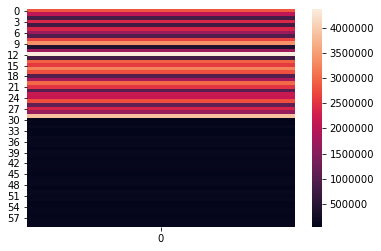

In [20]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(25962436., device='cuda:0')
tensor(333885.6875, device='cuda:0')


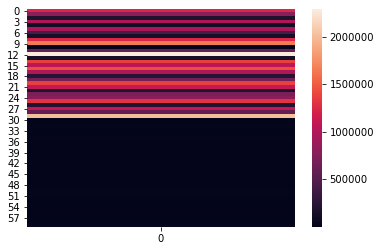

In [21]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(7655.0400, device='cuda:0')
tensor(3864.9590, device='cuda:0')


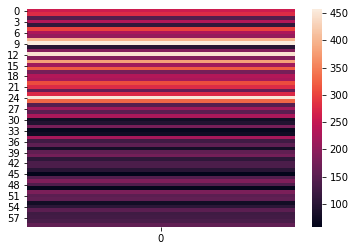

In [22]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2363.1196, device='cuda:0')
tensor(516.8802, device='cuda:0')


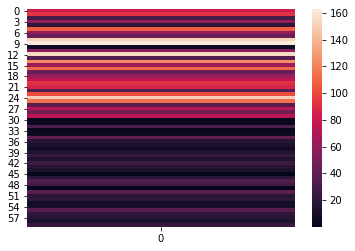

In [23]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [24]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(1846.2394, device='cuda:0')

In [25]:
w = gumbel_keys(vae_gumbel_truncated.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
w = torch.softmax(w/vae_gumbel_truncated.t, dim = -1)
w = w.sum(dim = 0)


In [26]:
top_ind = torch.argsort(w, descending = True)[:vae_gumbel_truncated.k]
top_ind


tensor([20,  9,  1, 21, 23, 25, 12, 11, 40, 51, 27,  8, 26, 43, 18, 31, 24, 56,
        19,  5,  6, 16,  7, 35], device='cuda:0')

In [27]:
sum(top_ind < 30)

tensor(18, device='cuda:0')

In [28]:
sum(top_ind >= 30)

tensor(6, device='cuda:0')

In [33]:
sum(w > 0.1)

tensor(19, device='cuda:0')

In [34]:
w[w>0.1]

tensor([2.0000, 1.0000, 2.0000, 1.0000, 1.0000, 1.0000, 0.9843, 2.0000, 2.0000,
        2.0000, 1.0000, 1.0002, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9995], device='cuda:0', grad_fn=<IndexBackward>)